In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.optim import Adam
import torchvision

import data

In [2]:
def whitening(weights, axis=0):
    mean = weights.mean(axis=axis)
    std = weights.std(axis=axis)
    return (weights - mean) / std

def generate_weights(rows, columns=1):
    return np.reshape([np.random.randn() for _ in range(rows*columns)], (rows, columns))

In [3]:
class PTDeep(nn.Module):
    def __init__(self, layers, activation):
        """Arguments:
           - layers: list containing number of neurons for each layer
           - activation: non-linear activation function
        """
        super(PTDeep, self).__init__()

        self.weights = nn.ParameterList([])
        self.biases = nn.ParameterList([])
        self.activation = activation

        for i, layer in enumerate(layers):
            if i == 0:
                continue
            
            self.weights.append(nn.Parameter(torch.from_numpy(whitening(generate_weights(layers[i-1], layer)))))
            self.biases.append(nn.Parameter(torch.from_numpy(whitening(generate_weights(1, layer), axis=1))))

    def forward(self, X, test=False):
        # unaprijedni prolaz modela: izračunati vjerojatnosti
        #   koristiti: torch.mm, torch.softmax

        S = torch.mm(X.double(), self.weights[0]) + self.biases[0]

        # Batch normalization
        if ~test:
            S = (S - S.mean(dim=1).view(-1,1)) / torch.sqrt(S.std(dim=1).view(-1,1))

        for i, (W, b) in enumerate(zip(self.weights, self.biases)):
            if i == 0:
                continue

            H = self.activation(S)
            S = torch.mm(H, W) + b

            # Batch normalization
            if ~test:
                mean = S.mean(dim=1)
                std = S.std(dim=1)
                S = (S - S.mean(dim=1).view(-1,1)) / torch.sqrt(S.std(dim=1).view(-1,1))

        self.probs = torch.softmax(S - torch.max(S, 1)[0].view(-1, 1), 1, torch.float)
        self.logprobs = F.log_softmax(S, dim=1)

    def get_loss(self, X, Yoh_):
        # formulacija gubitka
        #   koristiti: torch.log, torch.mean, torch.sum

        # logprobs = torch.log(self.probs)
        loss = - torch.mean(torch.sum(self.logprobs * Yoh_, axis=1))
        return loss


    def get_high_loss_data_indexes(self, X, Yoh_, top_k=5):
        # Pronalazi k indeksa slika za koje je gubitak najveci

        logprobs = torch.log(self.probs)
        arr = torch.sum(logprobs * Yoh_, axis=1).detach().numpy().ravel()
        return arr.argsort()[-top_k:][::-1]


    def count_params(self):
        total_params = 0
        for name, param in self.named_parameters():
            total_params += param.size()[0]*param.size()[1]
            print(f'name: {name}, size: {param.size()}')
        print('total parameters:', total_params)

In [4]:
def train(model, X, Yoh_, param_niter, param_delta, param_lambda=1e-4):
    """Arguments:
    - X: model inputs [NxD], type: torch.Tensor
    - Yoh_: ground truth [NxC], type: torch.Tensor
    - param_niter: number of training iterations
    - param_delta: learning rate
    """
    
    # inicijalizacija optimizatora
    optimizer = SGD(model.parameters(), lr=param_delta, weight_decay=param_lambda)

    losses = []

    # petlja učenja
    for i in range(param_niter):
        # Prolaz unaprijed
        model.forward(X)

        # Dohvati gubitak
        loss = model.get_loss(X, Yoh_)

        # računanje gradijenata
        loss.backward()

        # korak optimizacije
        optimizer.step()

        # Postavljanje gradijenata na nulu
        optimizer.zero_grad()

        losses.append(loss)
        print(f'step: {i}, loss:{loss}')
    return losses

In [5]:
def train_mb(model, X, Yoh_, param_epochs, param_batches, param_delta, param_lambda=1e-4):

    # inicijalizacija optimizatora
    optimizer = Adam(model.parameters(), lr=param_delta, weight_decay=param_lambda)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=1-1e-4)

    for epoch in range(param_epochs):

        # mijesaj podatke
        # podijeli u grupe
        idx = torch.randperm(X.size()[0])
        X = X[idx]
        Yoh_ = Yoh_[idx]

        batch_len = len(X) / param_batches

        for cur_batch in range(param_batches):

            batch_idx = torch.tensor(np.arange(cur_batch * batch_len, (cur_batch+1)*batch_len), dtype=torch.long)
            X_batch = X[batch_idx]
            Yoh_batch = Yoh_[batch_idx]

            # Prolaz unaprijed
            model.forward(X_batch)

            # Dohvati gubitak
            loss = model.get_loss(X_batch, Yoh_batch)

            # računanje gradijenata
            loss.backward()

            # korak optimizacije
            optimizer.step()

            # Postavljanje gradijenata na nulu
            optimizer.zero_grad()

            # Korak schedulera
            scheduler.step()

            print(f'batch: {cur_batch+1}/{param_batches}, epoch: {epoch+1}, loss:{loss}')

In [6]:
def eval(model, X):
    """Arguments:
        - model: type: PTLogreg
        - X: actual datapoints [NxD], type: np.array
        Returns: predicted class probabilites [NxC], type: np.array
    """
    # ulaz je potrebno pretvoriti u torch.Tensor
    # izlaze je potrebno pretvoriti u numpy.array
    # koristite torch.Tensor.detach() i torch.Tensor.numpy()
    model.forward(X, test=True)
    return model.probs.detach().numpy()

In [7]:
def pt_deep_decfun(model):
    return lambda X: eval(model, X)[np.arange(len(X)), 1]

In [8]:
def show_weight_matrix(model):
    # Ispis matrice težina za model konfiguracije [784, 10] 
    W = model.weights[0].detach().numpy()
    print(W)
    df = pd.DataFrame(W)
    display(df.corr())
    df.plot(subplots=True)
    plt.show()

In [9]:
def show_high_loss_pics(model, x_train, y_oh_train):
    D = x_train.shape[1] * x_train.shape[2]
    pic_index = model.get_high_loss_data_indexes(x_train.view(-1, D), y_oh_train, 3)

    for i in pic_index:
        plt.imshow(x_train[i,:,:], cmap = plt.get_cmap('gray'))
        plt.show()

Ucitavanje podataka

In [10]:
# inicijaliziraj generatore slučajnih brojeva
np.random.seed(100)

config = [784, 10]

dataset_root = '/tmp/mnist'  # change this to your preference
mnist_train = torchvision.datasets.MNIST(dataset_root, train=True, download=True)
mnist_test = torchvision.datasets.MNIST(dataset_root, train=False, download=True)

x_train, y_train = mnist_train.data, mnist_train.targets
x_test, y_test = mnist_test.data, mnist_test.targets
x_train, x_test = x_train.float().div_(255.0), x_test.float().div_(255.0)

y_oh_train = F.one_hot(y_train, config[-1])
y_oh_test = F.one_hot(y_test, config[-1])

N = x_train.shape[0]
D = x_train.shape[1] * x_train.shape[2]
C = y_train.max().add_(1).item()

Iscrtajte i komentirajte naučene matrice težina za svaku pojedinu znamenku

step: 0, loss:5.051375617511604
step: 1, loss:5.007113733221695
step: 2, loss:4.963115539336235
step: 3, loss:4.919379980649155
step: 4, loss:4.875906302996086
step: 5, loss:4.832694010429847
step: 6, loss:4.789742821207344
step: 7, loss:4.747052622952134
step: 8, loss:4.704623427384079
step: 9, loss:4.662455325029014
step: 10, loss:4.6205484403358925
step: 11, loss:4.57890288763601
step: 12, loss:4.537518728379399
step: 13, loss:4.496395930076736
step: 14, loss:4.45553432736311
step: 15, loss:4.414933585581384
step: 16, loss:4.374593167258831
step: 17, loss:4.334512301820574
step: 18, loss:4.294689958847054
step: 19, loss:4.255124825140685
step: 20, loss:4.21581528581985
step: 21, loss:4.176759409607172
step: 22, loss:4.137954938425714
step: 23, loss:4.099399281362681
step: 24, loss:4.06108951300739
step: 25, loss:4.02302237612017
step: 26, loss:3.985194288543321
step: 27, loss:3.947601354225558
step: 28, loss:3.910239378199112
step: 29, loss:3.873103885324792
step: 30, loss:3.8361901

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.040747,-0.016179,0.010265,-0.053086,0.014281,-0.005399,0.057054,-0.100554,0.051230
1,0.040747,1.000000,-0.002328,0.004717,-0.023618,0.027398,-0.046064,0.018966,0.031521,-0.025365
2,-0.016179,-0.002328,1.000000,0.108508,0.018513,-0.040236,0.029701,-0.062982,0.085694,-0.037550
3,0.010265,0.004717,0.108508,1.000000,-0.064886,-0.007664,0.016049,0.002363,0.012740,-0.031374
4,-0.053086,-0.023618,0.018513,-0.064886,1.000000,-0.070041,0.014750,0.012447,-0.041258,0.002105
5,0.014281,0.027398,-0.040236,-0.007664,-0.070041,1.000000,-0.046417,-0.027650,-0.027405,-0.017508
6,-0.005399,-0.046064,0.029701,0.016049,0.014750,-0.046417,1.000000,-0.008680,-0.053292,-0.021703
7,0.057054,0.018966,-0.062982,0.002363,0.012447,-0.027650,-0.008680,1.000000,0.018645,0.039508
8,-0.100554,0.031521,0.085694,0.012740,-0.041258,-0.027405,-0.053292,0.018645,1.000000,-0.066456
9,0.051230,-0.025365,-0.037550,-0.031374,0.002105,-0.017508,-0.021703,0.039508,-0.066456,1.000000


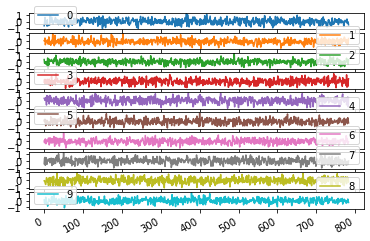

step: 0, loss:4.822183663436053
step: 1, loss:4.70341399605468
step: 2, loss:4.587449635587089
step: 3, loss:4.4742161231694935
step: 4, loss:4.363641746198562
step: 5, loss:4.2556574208063065
step: 6, loss:4.1501965157119605
step: 7, loss:4.04719460222854
step: 8, loss:3.9465891147808247
step: 9, loss:3.848318907722383
step: 10, loss:3.752323698555023
step: 11, loss:3.6585433960442098
step: 12, loss:3.5669173253378434
step: 13, loss:3.477383381795715
step: 14, loss:3.389877170675987
step: 15, loss:3.304331219412402
step: 16, loss:3.2206743791230426
step: 17, loss:3.138831555984595
step: 18, loss:3.058723922973704
step: 19, loss:2.9802697495207333
step: 20, loss:2.903385944400416
step: 21, loss:2.8279903353673737
step: 22, loss:2.754004617541429
step: 23, loss:2.6813578138221685
step: 24, loss:2.6099900366830315
step: 25, loss:2.5398563518887842
step: 26, loss:2.4709306295525275
step: 27, loss:2.4032093822753104
step: 28, loss:2.3367156081697766
step: 29, loss:2.271502428406382
step: 3

,0,1,2,3,4,5,6,7,8,9
0,1.000000,-0.132956,-0.070305,-0.062967,-0.220230,0.092915,-0.056875,-0.023720,-0.079232,-0.125405
1,-0.132956,1.000000,-0.053811,-0.074392,-0.122914,-0.158561,-0.071692,-0.116138,-0.001746,-0.132665
2,-0.070305,-0.053811,1.000000,0.011093,-0.178406,-0.226691,0.039811,-0.118718,-0.104168,-0.205579
3,-0.062967,-0.074392,0.011093,1.000000,-0.145097,0.050930,-0.223670,-0.058444,-0.100332,-0.124113
4,-0.220230,-0.122914,-0.178406,-0.145097,1.000000,-0.036788,0.045954,-0.131181,-0.052816,0.161059
5,0.092915,-0.158561,-0.226691,0.050930,-0.036788,1.000000,-0.078843,-0.175699,0.117201,-0.154389
6,-0.056875,-0.071692,0.039811,-0.223670,0.045954,-0.078843,1.000000,-0.186704,-0.117601,-0.124334
7,-0.023720,-0.116138,-0.118718,-0.058444,-0.131181,-0.175699,-0.186704,1.000000,-0.172424,0.103680
8,-0.079232,-0.001746,-0.104168,-0.100332,-0.052816,0.117201,-0.117601,-0.172424,1.000000,-0.079431
9,-0.125405,-0.132665,-0.205579,-0.124113,0.161059,-0.154389,-0.124334,0.103680,-0.079431,1.000000


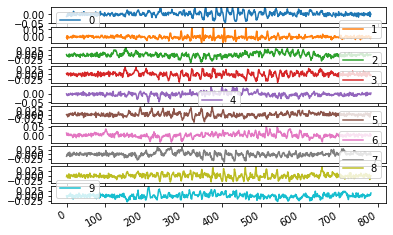

step: 0, loss:4.846888541453285
step: 1, loss:4.823703716316234
step: 2, loss:4.801004580459524
step: 3, loss:4.778747224173968
step: 4, loss:4.75689203220173
step: 5, loss:4.735403289860116
step: 6, loss:4.7142488190834255
step: 7, loss:4.6933996439348675
step: 8, loss:4.672829684548043
step: 9, loss:4.652515478068335
step: 10, loss:4.632435924929213
step: 11, loss:4.612572058678086
step: 12, loss:4.592906837528866
step: 13, loss:4.573424955840194
step: 14, loss:4.55411267378
step: 15, loss:4.5349576635250886
step: 16, loss:4.51594887044809
step: 17, loss:4.4970763878557625
step: 18, loss:4.478331343956904
step: 19, loss:4.459705799851092
step: 20, loss:4.441192657438522
step: 21, loss:4.422785576254912
step: 22, loss:4.404478898332229
step: 23, loss:4.386267580276337
step: 24, loss:4.368147131835101
step: 25, loss:4.350113560306276
step: 26, loss:4.33216332020327
step: 27, loss:4.31429326765874
step: 28, loss:4.29650061910228
step: 29, loss:4.278782913798292
step: 30, loss:4.26113797

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.041461,-0.045009,0.040736,-0.048413,-0.022545,-0.010881,0.034104,0.028242,-0.027611
1,0.041461,1.000000,0.035079,-0.035887,0.070704,0.044271,0.000575,0.084528,0.047615,0.061119
2,-0.045009,0.035079,1.000000,0.012136,0.039512,0.007150,-0.049986,0.013309,0.048467,0.024566
3,0.040736,-0.035887,0.012136,1.000000,0.027265,-0.008928,0.051257,-0.001415,0.034855,0.037275
4,-0.048413,0.070704,0.039512,0.027265,1.000000,0.001077,-0.000131,0.020193,-0.044033,-0.007585
5,-0.022545,0.044271,0.007150,-0.008928,0.001077,1.000000,-0.011291,-0.026468,-0.103117,-0.027009
6,-0.010881,0.000575,-0.049986,0.051257,-0.000131,-0.011291,1.000000,0.017504,0.002487,-0.000573
7,0.034104,0.084528,0.013309,-0.001415,0.020193,-0.026468,0.017504,1.000000,0.022283,-0.043100
8,0.028242,0.047615,0.048467,0.034855,-0.044033,-0.103117,0.002487,0.022283,1.000000,-0.021260
9,-0.027611,0.061119,0.024566,0.037275,-0.007585,-0.027009,-0.000573,-0.043100,-0.021260,1.000000


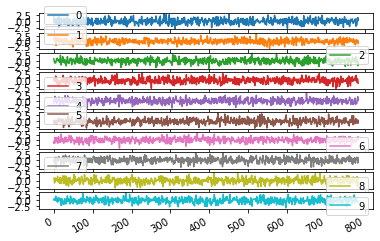

In [11]:
lambdas = [0.1, 0.5, 1e-4]
config = [784, 10]

for l in lambdas:
    model = PTDeep(config, torch.relu)
    train(model, x_train.view(-1, D), y_oh_train, 100, param_delta=0.1, param_lambda=l)
    show_weight_matrix(model)

Sto se misli pod iscrtaj? Ocekivao bih da ce znamenke koje slicno izgledaju imati vecu korelaciju izmedu vrijednosti matrice tezina, ali bas i nemaju. Sve su korelacije jako male, a na grafu je tesko ista interpretirati jer ima puno podataka. Pokusao sam prikazati i samo dio tezina, ali ni tamo nisam prepoznao uzorak koji sam ocekivao.

step: 0, loss:4.908366870791333
step: 1, loss:4.887578104278965
step: 2, loss:4.866989752782001
step: 3, loss:4.846600443672027
step: 4, loss:4.826408654702258
step: 5, loss:4.806412711813907
step: 6, loss:4.7866107883382
step: 7, loss:4.767000905523897
step: 8, loss:4.747580934313331
step: 9, loss:4.728348598285054

step: 0, loss:6.818369082872197
step: 1, loss:6.7212415151258735
step: 2, loss:6.628533081812818
step: 3, loss:6.5396803945835975
step: 4, loss:6.454226659459365
step: 5, loss:6.371790540131104
step: 6, loss:6.292065045669235
step: 7, loss:6.2147629309711485
step: 8, loss:6.1396390702987995
step: 9, loss:6.066483740578499


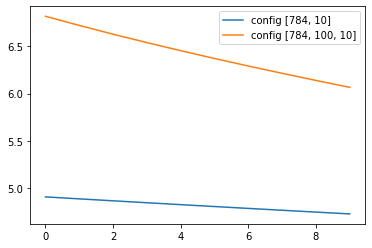

In [12]:
config1 = [784, 10]
model1 = PTDeep(config1, torch.relu)
losses1 = train(model1, x_train.view(-1, D), y_oh_train, 10, param_delta=0.1, param_lambda=1e-4)

print()

config2 = [784, 100, 10]
model2 = PTDeep(config2, torch.relu)
losses2 = train(model2, x_train.view(-1, D), y_oh_train, 10, param_delta=0.1, param_lambda=1e-4)

plt.plot(losses1, label='config [784, 10]')
plt.plot(losses2, label='config [784, 100, 10]')
plt.legend()
plt.show()

Vece arhitekture krecu sa vecom pogreskom, ali ona brzo opadne. Trebalo bi raditi vise epoha s manjim koracima da veca arhitektura konvergira.

step: 0, loss:5.93618210716194
step: 1, loss:5.825767532296207
step: 2, loss:5.7198113395924555
step: 3, loss:5.618142333287872
step: 4, loss:5.5205819307429
step: 5, loss:5.4269170826742705
step: 6, loss:5.336962052280923
step: 7, loss:5.250523449784997
step: 8, loss:5.167397664123137
step: 9, loss:5.08740376386778

step: 0, loss:6.174629407261883
step: 1, loss:6.086148992921244
step: 2, loss:6.001624941374509
step: 3, loss:5.920762833199969
step: 4, loss:5.843250953426311
step: 5, loss:5.768778992466456
step: 6, loss:5.697041508026361
step: 7, loss:5.627755258974085
step: 8, loss:5.560669413203594
step: 9, loss:5.495557438342285

step: 0, loss:6.270880141911001
step: 1, loss:6.1732197381552805
step: 2, loss:6.078585161896186
step: 3, loss:5.9868217884024855
step: 4, loss:5.8977917674599585
step: 5, loss:5.811380067402787
step: 6, loss:5.72747820560735
step: 7, loss:5.646007599805577
step: 8, loss:5.566896791182023
step: 9, loss:5.4900692092670225

step: 0, loss:6.305120014744636
step

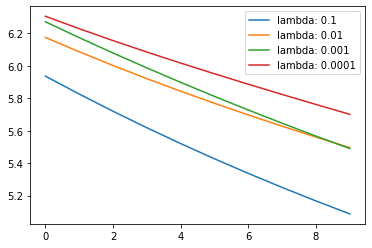

In [13]:
lambdas = [0.1, 0.01, 0.001, 1e-4]

for l in lambdas:
    config = [784, 100, 10]
    model = PTDeep(config, torch.relu)
    losses = train(model, x_train.view(-1, D), y_oh_train, 10, param_delta=0.1, param_lambda=1e-4)
    plt.plot(losses, label='lambda: ' + str(l))
    print()

plt.legend()
plt.show()

In [14]:
def train_validation_split(x, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    X_train = torch.from_numpy(X_train)
    X_val = torch.from_numpy(X_test)
    y_train = torch.from_numpy(y_train)
    y_val = torch.from_numpy(y_test)
    return X_train, X_val, y_train, y_val

In [15]:
config = [784, 10]
model = PTDeep(config, torch.relu)
train_mb(model, x_train.view(-1, D), y_oh_train, param_epochs=10, param_batches=100, param_delta=0.1, param_lambda=1e-4)

# dohvati vjerojatnosti na skupu za učenje
probs = eval(model, x_test.view(-1, D))
Y_pred = np.argmax(probs, axis=1)

# ispiši performansu (preciznost i odziv po razredima)
accuracy, pr, _ = data.eval_perf_multi(Y_pred, y_test)
print(f'accuracy: {accuracy}, precision: {pr[0]}, recall: {pr[1]}')

batch: 1/100, epoch: 1, loss:5.130166660478182
batch: 2/100, epoch: 1, loss:3.4424170346714655
batch: 3/100, epoch: 1, loss:2.4038146933202813
batch: 4/100, epoch: 1, loss:1.7599212922409933
batch: 5/100, epoch: 1, loss:1.2927270457269193
batch: 6/100, epoch: 1, loss:1.0398761198621571
batch: 7/100, epoch: 1, loss:0.8141701360671385
batch: 8/100, epoch: 1, loss:0.8225279159359812
batch: 9/100, epoch: 1, loss:0.7742815624158935
batch: 10/100, epoch: 1, loss:0.6766186683739299
batch: 11/100, epoch: 1, loss:0.6228750812159837
batch: 12/100, epoch: 1, loss:0.6189400702066076
batch: 13/100, epoch: 1, loss:0.5525034619157954
batch: 14/100, epoch: 1, loss:0.6031853222372358
batch: 15/100, epoch: 1, loss:0.5893531627276067
batch: 16/100, epoch: 1, loss:0.4659661750293056
batch: 17/100, epoch: 1, loss:0.5300184906966567
batch: 18/100, epoch: 1, loss:0.5703036227128735
batch: 19/100, epoch: 1, loss:0.45561950937312684
batch: 20/100, epoch: 1, loss:0.5120174599519945
batch: 21/100, epoch: 1, loss

Gubitak slucajno inicijaliziranog modela

In [16]:
model = PTDeep(config, torch.relu)
model.forward(x_train.view(-1, D))
print('loss:', model.get_loss(x_train, y_oh_train).item())

loss: 5.283034324999697


Linearni i jezgreni SVM za MNIST

In [18]:
for kernel in ['linear', 'rbf']:
    clf = SVC(kernel=kernel, gamma='auto', decision_function_shape='ovo')
    clf.fit(x_train.view(-1, D), y_train)
    y_pred = clf.predict(x_test.view(-1, D))

    # ispiši performansu (preciznost i odziv po razredima)
    accuracy, pr, _ = data.eval_perf_multi(y_pred, y_test)
    print(f'accuracy: {accuracy}, precision: {pr[0]}, recall: {pr[1]}')

accuracy: 0.9404, precision: (0.976530612244898, 0.9522388059701492), recall: (0.9885462555066079, 0.9697493517718236)
accuracy: 0.9446, precision: (0.986734693877551, 0.9593253968253969), recall: (0.9876651982378855, 0.968048359240069)
